# Project Introduction

In this project, we aim to develop and evaluate various machine learning models to predict health-related outcomes based on a structured dataset. The dataset contains multiple features representing individual health metrics and associated variables. By cleaning, preprocessing, and transforming the data, we will create a robust foundation for model training.

Our main objective is to compare different machine learning algorithms, assess their performance through F1 scores and accuracy, and select the best-performing model for deployment. This notebook will walk through each step in detail, from data loading and preprocessing to model training, evaluation, and result visualization.


### Load the Dataset

In this step, we load the dataset containing both training and testing data. The dataset includes features that represent health metrics and conditions of individuals, as well as the target variable for training, which indicates the presence or absence of a health outcome (e.g., disease). 

The dataset loading function will provide us with separate arrays for:
- `x_train`: Training features
- `x_test`: Testing features
- `y_train`: Training labels
- `train_ids` and `test_ids`: Unique identifiers for each individual in the training and testing sets, respectively.

These data arrays will serve as the basis for data cleaning, preprocessing, and model training.


In [3]:
import numpy as np
from helpers import *
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data('dataset')

### Cleaning Functions

The cleaning functions help prepare the dataset by addressing issues like missing values, low-variance features, and features with low correlation to the target variable. Each function is designed to handle a specific type of data cleaning.

These functions enable a structured approach to data cleaning, ensuring that the dataset is more relevant, informative, and well-suited for training machine learning models.

In [5]:
# Function to compute Pearson correlation scores between features and labels
def compute_pearson_cor(x, y):
    score = []
    y_err = y - np.mean(y)
    for j in range(x.shape[1]):
        x_err = x[:, j] - np.mean(x[:, j])
        r = float(np.sum(x_err * y_err) / np.sqrt(np.sum(x_err ** 2) * np.sum(y_err ** 2)))
        score.append(r)
    return score

In [6]:
# Function to remove features with Pearson correlation below a threshold
def remove_pearson_cor(x, r_min, scores, features_index):
    keep_mask = np.abs(scores) > r_min
    x = x[:, keep_mask]
    features_index = features_index[keep_mask]
    return x, features_index

In [7]:
# Function to plot Pearson correlation coefficients
def plot_pearson_correlations(scores):
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    sns.barplot(x=np.arange(len(scores)), y=scores, color='skyblue', edgecolor='black')
    plt.axhline(0, color='grey', linewidth=0.8)
    plt.title('Pearson Correlation Coefficients', fontsize=16, fontweight='bold')
    plt.xlabel('Features', fontsize=14)
    plt.ylabel('Correlation Coefficient (r)', fontsize=14)
    plt.show()

### Clean and Extend the Dataset

In this section, we apply the cleaning functions to prepare the dataset for modeling. Additionally, we extend the dataset by encoding categorical variables and handling specific feature values, based on domain knowledge described in the `variable_descriptions` file.

#### Steps in Cleaning and Extension:

1. **Parsing Variable Descriptions**: The dataset includes categorical variables that are parsed from `variable_descriptions.txt`. We extract and structure each variable’s details to facilitate the encoding process.

2. **Expanding Categorical Columns**: We define the `expand_column` function to handle each feature based on its description:
   - **Discrete Values**: Encodes as binary indicators.
   - **Ranges**: Encodes within specified ranges.
   - **Missing and Hidden Values**: Encodes missing values or replaces them with the column mean when specified.

3. **Concatenate Expanded Features**: Each categorical column is expanded based on its possible values, then concatenated to form the extended dataset with all new encoded features.

4. **Remove Low-Correlation Features**: Using Pearson correlation, we identify and remove features with a correlation below a specified threshold. This step reduces noise by retaining only the features most predictive of the target variable.

5. **Standardization**: Standardizes each feature by subtracting the mean and dividing by the standard deviation, ensuring all features are on a similar scale for effective model training.

This cleaning and extension process transforms the dataset into a structured, enriched format that improves model training efficiency and accuracy.

In [8]:
# Parse variable descriptions from a text file to create a structured dictionary
def parse_variable_descriptions(filepath):
    variable_descriptions = {}
    
    with open(filepath, 'r', encoding="utf-8") as file:
        lines = file.readlines()
        var_name, description, values = None, None, None

        for line in lines:
            line = line.strip()
            
            if line.startswith("SAS Variable Name:"):
                # Store previous variable description if available
                if var_name and description and values:
                    variable_descriptions[var_name] = {"description": description, "values": values}
                
                # Extract new variable name
                var_name = line.split(":")[1].strip()
                description, values = "", ""
            
            elif line.startswith("Description:"):
                description = line.split(":", 1)[1].strip()
            
            elif line.startswith("Values:"):
                values = line.split(":", 1)[1].strip()
        
        # Add the last variable if it exists
        if var_name and description and values:
            variable_descriptions[var_name] = {"description": description, "values": values}
    
    return variable_descriptions

In [9]:
variable_descriptions = parse_variable_descriptions('variable_descriptions.txt')

In [10]:
# Function to expand columns based on value descriptions
def expand_column(column, values):
    expanded_cols = []
    
    for value in values.split(','):
        value = value.strip()
        
        if "-" in value:  # Range handling
            min_val, max_val = map(int, value.split('-'))
            expanded_col = np.where((column >= min_val) & (column <= max_val), column, 0)
        
        elif value.isdigit():  # Discrete number handling
            expanded_col = (column == int(value)).astype(int)
        
        elif value == "BLANK":  # Handle missing (BLANK) values
            expanded_col = np.isnan(column).astype(int)
        
        elif value == "HIDDEN":  # Handle HIDDEN values
            column_mean = np.nanmean(column)
            expanded_col = np.where(np.isnan(column), column_mean, column)
        
        expanded_cols.append(expanded_col)
    
    return np.column_stack(expanded_cols)

In [11]:
# Expanding x_train and x_test
def expand_dataset(x, variable_descriptions):
    expanded_columns = []

    for idx, (col_name, desc) in enumerate(variable_descriptions.items()):
        column = x[:, idx]  # Extract column data
        values = desc["values"]
        expanded_col = expand_column(column, values)
        expanded_columns.append(expanded_col)

    return np.hstack(expanded_columns)

In [12]:
x_train_expanded = expand_dataset(x_train, variable_descriptions)
x_test_expanded = expand_dataset(x_test, variable_descriptions)

print("Expanded x_train shape:", x_train_expanded.shape)
print("Expanded x_test shape:", x_test_expanded.shape)

Expanded x_train shape: (328135, 1868)
Expanded x_test shape: (109379, 1868)


C:\Users\Mokni\AppData\Local\Temp\ipykernel_27064\3603739794.py:7: RuntimeWarning: invalid value encountered in scalar divide
  r = float(np.sum(x_err * y_err) / np.sqrt(np.sum(x_err ** 2) * np.sum(y_err ** 2)))


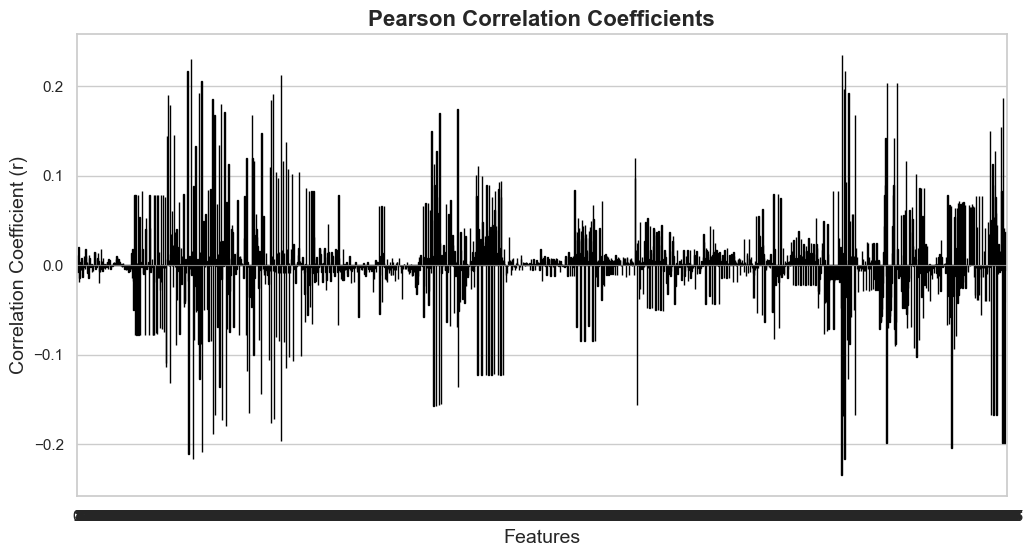

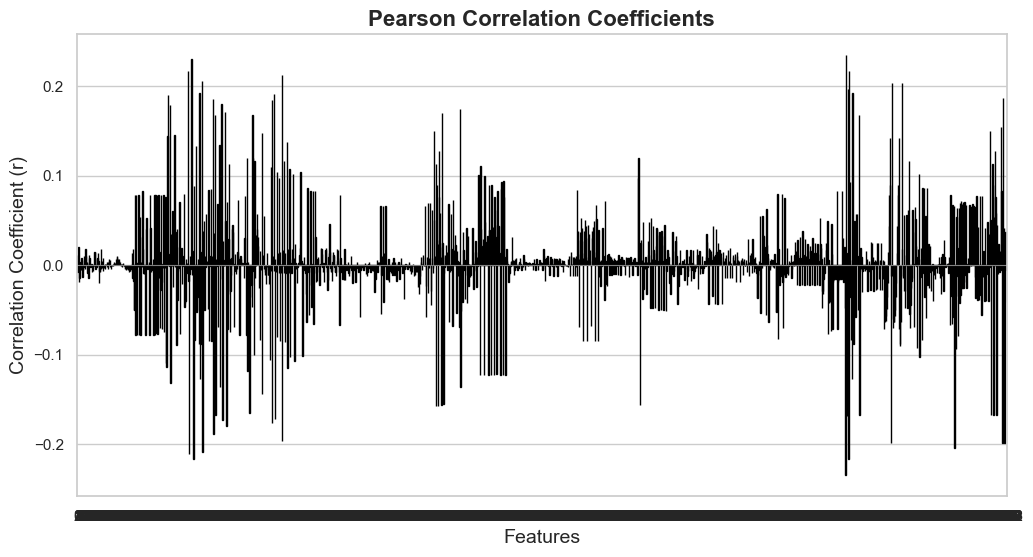

Shapes after Pearson filter: (109379, 1854) (328135, 1854)


In [13]:
# Remove features with Pearson correlation below a threshold
r_min = 0.0
features_index = np.arange(0, x_train_expanded.shape[1])
scores = compute_pearson_cor(x_train_expanded, y_train)

# Plot initial Pearson correlation scores
plot_pearson_correlations(scores)

x_train_expanded, features_index = remove_pearson_cor(x_train_expanded, r_min, scores, features_index)
scores_new = compute_pearson_cor(x_train_expanded, y_train)

# Plot updated Pearson correlation scores
plot_pearson_correlations(scores_new)
x_test_expanded = x_test_expanded[:, features_index]
print("Shapes after Pearson filter:", x_test_expanded.shape, x_train_expanded.shape)

In [14]:
# Standardize the dataset
def standardize_dataset(x_train, x_test):
    y_train_expanded = np.expand_dims(y_train, axis=1)

    std = np.std(x_train, axis=0)
    cols_to_keep = std != 0

    x_train = x_train[:, cols_to_keep]
    x_test = x_test[:, cols_to_keep]

    mean = np.mean(x_train, axis=0)
    std = np.std(x_train, axis=0)

    x_train = (x_train - mean) / std
    x_test = (x_test - mean) / std
    return x_train, x_test, y_train_expanded

In [16]:
x_train_expanded, x_test_expanded, y_train = standardize_dataset(x_train_expanded, x_test_expanded)

In [18]:
print("Final shapes - x_train:", x_train_expanded.shape, "x_test:", x_test_expanded.shape)

Final shapes - x_train: (328135, 1854) x_test: (109379, 1854)


### Train the ML Model

In this section, we import the machine learning models defined in the `implementations.py` file, which include:

- **Least Squares**: Ordinary least squares linear regression to minimize Mean Squared Error (MSE).
- **Logistic Regression**: Logistic regression for binary classification using gradient descent.
- **Mean Squared Error Gradient Descent**: Linear regression using gradient descent to minimize MSE.
- **Mean Squared Error Stochastic Gradient Descent**: Linear regression using stochastic gradient descent to minimize MSE.
- **Ridge Regression**: Regularized linear regression to handle multicollinearity and improve generalization.
- **Regularized Logistic Regression**: Logistic regression with L2 regularization for improved generalization.

Each model will be trained and evaluated using the processed training and validation data. We will compare models based on their F1 scores and accuracy, selecting the best-performing model for final predictions.

In [19]:
from implementations import (
    least_squares,
    logistic_regression,
    mean_squared_error_gd,
    mean_squared_error_sgd,
    ridge_regression,
    reg_logistic_regression,
)

In [20]:
# Set parameters
TRAIN_SPLIT_RATIO = 0.9
TRAIN_POSITIVE_RATIO = 0.22
RANDOM_SEED = 43504
np.random.seed(RANDOM_SEED)

In [21]:
# Splitting the dataset
def split_and_balance_data(x_data, y_data, split_ratio=TRAIN_SPLIT_RATIO, positive_ratio=TRAIN_POSITIVE_RATIO):
    split_indices = np.random.permutation(x_data.shape[0])
    split_index = int(split_ratio * x_data.shape[0])
    
    # Split train and validation indices
    train_indices, val_indices = split_indices[:split_index], split_indices[split_index:]
    x_train, y_train = x_data[train_indices], y_data[train_indices]
    x_val, y_val = x_data[val_indices], y_data[val_indices]
    
    # Separate positive and negative samples in the training set
    pos_indices, neg_indices = np.where(y_train == 1)[0], np.where(y_train == -1)[0]
    n_pos, n_total = len(pos_indices), int(len(pos_indices) / positive_ratio)
    n_neg = n_total - n_pos

    sampled_neg_indices = np.random.choice(neg_indices, min(n_neg, len(neg_indices)), replace=False)
    repeated_pos_indices = np.random.choice(pos_indices, n_total - len(sampled_neg_indices), replace=True)
    
    balanced_indices = np.concatenate([repeated_pos_indices, sampled_neg_indices])
    np.random.shuffle(balanced_indices)
    
    return x_train[balanced_indices], y_train[balanced_indices], x_val, y_val

In [22]:
x_train_split, y_train_split, x_val_split, y_val_split = split_and_balance_data(x_train_expanded, y_train)

In [ ]:
# Map labels from -1, 1 to 0, 1
y_train_split = (y_train_split + 1) / 2
y_val_split = (y_val_split + 1) / 2

In [ ]:
# Function to predict outcomes
def predict(tx, w):
    pred_prob = sigmoid(tx.dot(w))
    return np.where(pred_prob >= 0.5, 1, 0)

In [ ]:
# Function to evaluate precision, recall and F1 score
def calculate_precision_recall_f1(y_true, y_pred):
    true_positive = np.sum((y_true == 1) & (y_pred == 1))
    false_positive = np.sum((y_true == 0) & (y_pred == 1))
    false_negative = np.sum((y_true == 1) & (y_pred == 0))
    precision = true_positive / (true_positive + false_positive + 1e-15)
    recall = true_positive / (true_positive + false_negative + 1e-15)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-15)
    return precision, recall, f1_score

In [ ]:
# Updated function to evaluate a model's performance
def evaluate_model(model_func, x_train, y_train, x_val, y_val, *args):
    tx_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
    tx_val = np.c_[np.ones((x_val.shape[0], 1)), x_val]
    
    # Train model
    w, _ = model_func(y_train, tx_train, *args)
    
    # Predict and evaluate
    y_val_pred = predict(tx_val, w)
    _, _, f1 = calculate_precision_recall_f1(y_val, y_val_pred)
    
    return f1

In [ ]:
# Define model hyperparameters
initial_w = np.zeros((x_train_split.shape[1] + 1, 1))  # Adding +1 for bias term
max_iters = 150
gamma = 0.1
lambda_ = 0.01

In [ ]:
# Dictionary to hold results for each model
results = {}

In [ ]:
# Testing each model
results['Least Squares'] = evaluate_model(
    least_squares, x_train_split, y_train_split, x_val_split, y_val_split
    )

In [ ]:
results['Logistic Regression'] = evaluate_model(
    logistic_regression, x_train_split, y_train_split, x_val_split, y_val_split, initial_w, max_iters, gamma
    )

In [ ]:
results['Ridge Regression'] = evaluate_model(
    ridge_regression, x_train_split, y_train_split, x_val_split, y_val_split, lambda_
    )

In [ ]:
results['Mean Squared Error GD'] = evaluate_model(
    mean_squared_error_gd, x_train_split, y_train_split, x_val_split, y_val_split, initial_w, max_iters, gamma
    )

c:\Users\Abdou2\OneDrive\Bureau\ML project 1\ml-project-1-quantum-minds\helpers.py:77: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-t))


In [ ]:
results['Mean Squared Error SGD'] = evaluate_model(
    mean_squared_error_sgd, x_train_split, y_train_split, x_val_split, y_val_split, initial_w, max_iters, gamma
    )

In [ ]:
results['Reg Logistic Regression'] = evaluate_model(
    reg_logistic_regression, x_train_split, y_train_split, x_val_split, y_val_split, lambda_, initial_w, max_iters, gamma
)

In [ ]:
# Display the results
for model_name, f1 in results.items():
    print(f"{model_name}: F1 Score = {f1:.4f}")

Least Squares: F1 Score = 0.2041
Logistic Regression: F1 Score = 0.4473
Ridge Regression: F1 Score = 0.2058
Mean Squared Error GD: F1 Score = 0.1803
Mean Squared Error SGD: F1 Score = 0.2162
Reg Logistic Regression: F1 Score = 0.4473


C:\Users\Abdou2\AppData\Local\Temp\ipykernel_15400\3195111741.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=f1_scores, palette="Blues_d")


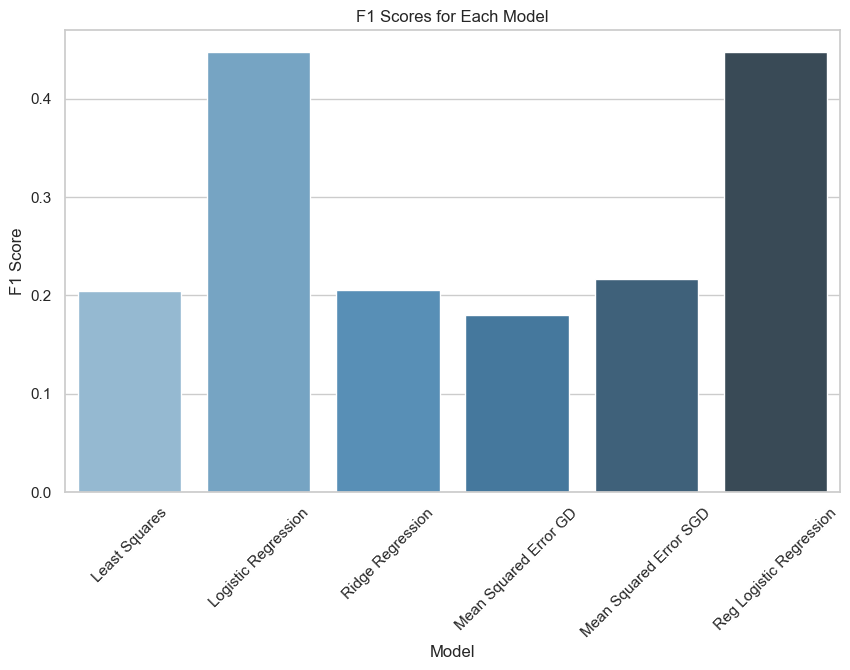

In [ ]:
# Convert results to lists for plotting
model_names = list(results.keys())
f1_scores = results.values()

# Plot F1 Scores
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=f1_scores, palette="Blues_d")
plt.title("F1 Scores for Each Model")
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.show()

### Custom Logistic Regression with Gradient Descent and Regularization

In this section, we implemented a custom logistic regression model using gradient descent with L2 regularization. This approach allowed us to optimize the F1 score effectively.

Key Functions:
- **`calculate_gradient`**: Computes the gradient of the loss function with regularization for each feature.
- **`predict`**: Generates predictions based on a thresholded probability.
- **`calculate_loss`**: Calculates the regularized loss function, including a penalty term for model weights.
- **`learning_by_gradient_descent`**: Updates the model weights iteratively using gradient descent.
- **`logistic_regression_variation`**: Integrates all functions to perform regularized logistic regression, keeping track of the best F1 score achieved.

This custom approach gave us our best F1 score, as it balances the model complexity with generalization through regularization, effectively handling potential overfitting issues.

In [ ]:
def calculate_gradient(y, tx, w, lambda_):
    pred = sigmoid(tx.dot(w))
    grad = tx.T.dot(pred-y) / y.shape[0]
    grad[1:] += lambda_ * w[1:]
    return grad

def predict(tx, w):
    pred_prob = sigmoid(tx.dot(w))
    return np.where(pred_prob >= 0.5, 1, 0)

def calculate_loss(y, tx, w, lambda_):
    pred = sigmoid(tx.dot(w))
    regularization = (lambda_ / 2) * sum(w[1:]**2)
    loss = -np.mean(y * np.log(pred + 1e-120) + (1-y) * np.log(1 - pred + 1e-120)) + regularization
    return loss

def learning_by_gradient_descent(y, tx, w, gamma, lambda_):
    loss = calculate_loss(y, tx, w, lambda_)
    grad = calculate_gradient(y, tx, w, lambda_)
    w -= gamma*grad
    return loss, w

def logistic_regression_variation(y_train, x_train, y_val, x_val):
    max_iters = 150
    threshold = 1e-8
    gamma = 0.1
    lambda_ = 0.01
    losses = []
    tx_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
    tx_val = np.c_[np.ones((x_val.shape[0], 1)), x_val]
    w = np.zeros((tx_train.shape[1], 1))
    f1_best = 0
    w_best = w
    
    for _ in range(max_iters):
        # Perform one step of penalized gradient descent
        loss, w = learning_by_gradient_descent(y_train, tx_train, w, gamma, lambda_)
        y_val_pred = predict(tx_val, w)
        _,_,f1_score = calculate_precision_recall_f1(y_val, y_val_pred)

        if(f1_score > f1_best):
            w_best = w.copy()
            f1_best = f1_score
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    print(f"Best f1-score: {f1_best}")
    return w_best, f1_best

w_best, f1_best = logistic_regression_variation(y_train_split, x_train_split, y_val_split, x_val_split)

Best f1-score: 0.4529963078670827


In [ ]:
# Save the predictions
tx_test = np.c_[np.ones((x_test_expanded.shape[0], 1)), x_test_expanded]
y_test_pred = predict(tx_test, w_best)
y_test_pred = y_test_pred * 2 - 1  # Map back to -1 and 1

# Save the predictions
create_csv_submission(test_ids, y_test_pred, "predictions.csv")